# ДЗ 1, часть 3. ЕМ-алгоритм

Имя, Фамилия: Вадим Палысаев

группа: БПМИ 223

**Оценка(для проверяющего):** 0 из 10

**Дедлайн:** 5 ноября 23:59 (решение нужно сдать в энитаск)

In [132]:
#all imports here please
import pickle as pkl
import tqdm
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal
from scipy.stats import lognorm, expon

## Задача 1. Поломки (5 баллов)

В офисе одного небольшого СобериБанка происходят поломки серверной. Служба обслуживания в таких случаях посылает специалиста решить проблему.  Для этого необходимо произвести обслуживание вычислительного узла А и вычислительного узла B. Каждый специалист имеет какую-то свою инструкцию, методологию, а также свой опыт, который определяет то, как именно он занимается ремонтном, и то, сколько времени у него занимают ремонтные работы.

В офисе точно могут сказать, сколько суммарно времени занял ремонт каждого из узлов(в минутах), обозначим их за переменные $X_A,~X_B$, но очень сложно понять, какие конкретно рабочие занимались ремонтом в каждом случае.

Коллеги вас, как экперта в статистике, просят оценить, сколько рабочих занято в ремонте вашей серверной. Немного посидев в браузере, вы узнаёте, что, оказывается, времена обслуживания техники можно моделировать с помощью знакомого [логнормального распределения](https://en.wikipedia.org/wiki/Log-normal_distribution).

Используя ЕМ-алгоритм, модель смеси распределений, а также приложенный датасет, определите сколько рабочих могло участвовать в ремонте серверной за время наблюдений. Можете ли вы определить, какой рабочий участвовал в каждом ремонте?

Действуем по инструкции.

### Посмотрим на датасет

Откройте приложенный датасет и нарисуйте диаграмму разброса (scatterplot) в осях $X_A,~X_B$, чтобы посмотреть, что в целом дано. Возможно, удобнее перейти в логарифмические оси.

In [8]:
with open("./maintenance.pkl","rb") as f:
    dd = pkl.load(f)

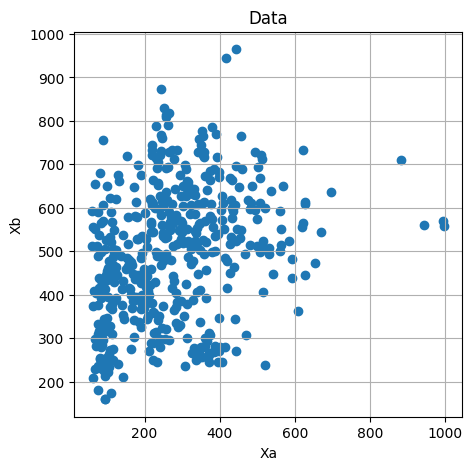

In [9]:
Xa = dd['times(min)'][:, 0]
Xb = dd['times(min)'][:, 1]

f,ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Data")
ax.scatter(Xa, Xb)
ax.set_xlabel("Xa")
ax.set_ylabel("Xb")
plt.show()

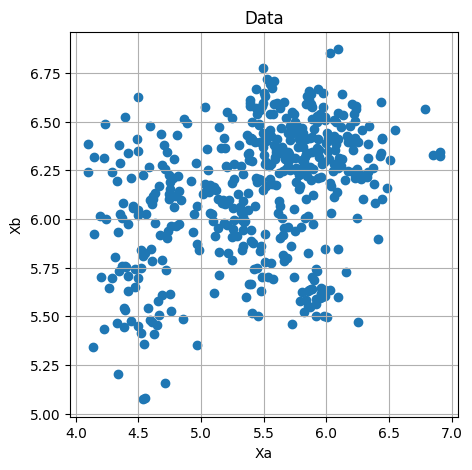

In [10]:
f,ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Data")
ax.scatter(np.log(Xa), np.log(Xb))
ax.set_xlabel("Xa")
ax.set_ylabel("Xb")
plt.show()

### Модель

Опишите модель смеси, которая вам пригодится для решения задачи. Число компонент будем определять экспериментально, а остальное надо оценивать. Предполагается, что вектор $[\ln X_A, \ln X_B]$ у каждого рабочего имеет нормальное распределение. Логарифмы $\ln X_A$ и $\ln X_B$ могут быть коррелированы, но пары  $(X^i_A,X^i_B)$ независимы в совокупности.

* Что по смыслу задачи является скрытыми переменными $Y_i$ (номерами компонент)?
* Какое вы можете предложить распределение для пары $(X^i_A, X^i_B)$? Будьте здесь внимательны!
* Какие параметры $\theta$ есть в вероятностной модели?

1) Скрытыми переменными $ Y_i $ являются конкретные рабочие, которые занимались ремонтом узлов в каждом наблюдении (то есть их идентификаторы). Эти скрытые переменные $ Y_i $ определяют, какой из рабочих (компонентов смеси) выполнял ремонт для данной пары времен обслуживания $ (X_A, X_B) $.

2) Для каждой пары $ (X_A, X_B) $ предполагается логнормальное распределение, поскольку предполагается, что вектор $[\ln X_A, \ln X_B]$ у каждого рабочего имеет нормальное распределение.

Таким образом, распределение для каждой пары $ (X_A, X_B) $ можно описать как:

$$
\ln(X_A, X_B) \sim \mathcal{N}(\mu_k, \Sigma_k),
$$

где $ \mu_k $ это среднее значение

и $ \Sigma_k $ это ковариационная матрица.

3) В данной модели параметры $ \theta $:

Векторы средних значений $ \mu_k = (\mu_{kA}, \mu_{kB}) $,

ковариационные матрицы $ \Sigma_k $ и

веса компонентов смеси $ \pi_k $.


### Матчасть

Построим математическую основу решения задачи. Выведите и запишите формулы для ЕМ-алгоритма: Е-шаг (вычисление необходимых весов наблюдений) и М-шаг (обновление параметров).

##E-шаг: Вычисление весов $ \gamma_{ik} $

Для каждого наблюдения $ X_i $ мы хотим вычислить апостериорные вероятности (веса) того, что это наблюдение принадлежит компоненте $ k $, то есть $ \gamma_{ik} = p(Y_i = k \mid X_i) $. Выразим это через формулу Байеса:

$$
\gamma_{ik} = p(Y_i = k \mid X_i) = \frac{p(X_i, Y_i = k)}{p(X_i)} = \frac{p(X_i \mid Y_i = k) \cdot P(Y_i = k)}{p(X_i)}
$$

Выразим $ p(X_i) $ как сумму по всем компонентам смеси:

$$
p(X_i) = \sum_{j=1}^K p(X_i \mid Y_i = j) \cdot P(Y_i = j)
$$

Тогда формула для $ \gamma_{ik} $:

$$
\gamma_{ik} = \frac{p(X_i \mid Y_i = k) \cdot \pi_k}{\sum_{j=1}^K p(X_i \mid Y_i = j) \cdot \pi_j}
$$

где:

$ p(X_i \mid Y_i = k) $ - плотность нормального распределения для компоненты $ k $ и наблюдения $ X_i $,

$ \pi_k = P(Y_i = k) $ - вероятность компоненты $ k $.

\

###Q-функция: $ Q(\theta_0, \theta) $

Теперь, на основе вычисленных весов $ \gamma_{ik} $, определим $ Q $-функцию, которая представляет собой ожидаемое значение полной функции правдоподобия:

$$
Q(\theta_0, \theta) = \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik} \left( \ln \pi_k + \ln p(X_i \mid Y_i = k) \right)
$$

Подставим выражение для плотности нормального распределения:

$$
Q(\theta_0, \theta) = \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik} \left( \ln \pi_k + \ln \left( \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}} \exp \left( -\frac{1}{2} (X_i - \mu_k)^T \Sigma_k^{-1} (X_i - \mu_k) \right) \right) \right)
= \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik} \left( \ln \pi_k - \frac{d}{2} \ln (2\pi) - \frac{1}{2} \ln |\Sigma_k| - \frac{1}{2} (X_i - \mu_k)^T \Sigma_k^{-1} (X_i - \mu_k) \right)
$$

где $ d $ — размерность данных (точнее $ d = 2 $ тк $ (\ln X_A, \ln X_B) $).

\

##M-шаг: Обновление параметров

Теперь максимизируем $ Q(\theta_0, \theta) $ по параметрам $ \pi_k $, $ \mu_k $ $ \Sigma_k $:

###Оптимизация по $ \pi_k $

Функция Лагранжа:

$$
L(\theta_0, \theta) = Q(\theta_0, \theta) + \lambda \left( \sum_{k=1}^K \pi_k - 1 \right)
$$

Оптимизируем по $ \lambda $:

$$
\frac{\partial L(\theta_0, \theta)}{\partial \lambda} = \frac{\partial}{\partial \lambda} \left( Q(\theta_0, \theta) + \lambda \left( \sum_{k=1}^K \pi_k - 1 \right) \right) = 0
$$

Тогда:

$$ \sum_{k=1}^K \pi_k = 1 $$

Теперь оптимизируем по $ \pi_k $:

$$
\frac{\partial}{\partial \pi_k} \left( \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik} \ln \pi_k + \lambda \left( \sum_{k=1}^K \pi_k - 1 \right) \right) = 0
$$

$$
\frac{\lambda}{\pi_k} + \sum_{i=1}^N \gamma_{ik} = 0
$$

$$
\pi_k = -\frac{\sum_{i=1}^N \gamma_{ik}}{\lambda}
$$

Подставим это в условие нормировки:

$$
-\frac{\sum_{k=1}^K \sum_{i=1}^N \gamma_{ik}}{\lambda} = 1  
$$

Отсюда следует что $\lambda = -N$.

Тогда:

$$
\pi_k = \frac{\sum_{i=1}^N \gamma_{ik}}{N}
$$

### Оптимизация по $ \mu_k $

Максимизируем и вычислим производную $ Q(\theta_0, \theta) $ по $ \mu_k $:

$$
\frac{\partial}{\partial \mu_k} Q(\theta_0, \theta) = \frac{\partial}{\partial \mu_k} \left( -\frac{1}{2} \sum_{i=1}^N \gamma_{ik} (\ln X_i - \mu_k)^T \Sigma_k^{-1} (\ln X_i - \mu_k) \right)
= -\frac{1}{2} \sum_{i=1}^N \gamma_{ik} \left( -2 \Sigma_k^{-1} (\ln X_i - \mu_k) \right)
= \sum_{i=1}^N \gamma_{ik} \Sigma_k^{-1} (\ln X_i - \mu_k)
$$

Приравниваем производную к нулю для нахождения точки максимума:

$$
\sum_{i=1}^N \gamma_{ik} \Sigma_k^{-1} (\ln X_i - \mu_k) = 0
$$

Домножим на $ \Sigma_k $ слева, чтобы избавиться от инверсии:

$$
\sum_{i=1}^N \gamma_{ik} \ln X_i - \mu_k \sum_{i=1}^N \gamma_{ik} = 0
$$

Отсюда выразим $ \mu_k $:

$$
\mu_k = \frac{\sum_{i=1}^N \gamma_{ik} \ln X_i}{\sum_{i=1}^N \gamma_{ik}}
$$

### Оптимизация по $ \Sigma_k $

Теперь максимизируем $ Q(\theta_0, \theta) $ по $ \Sigma_k $:

$$
Q(\theta_0, \theta) = -\frac{1}{2} \sum_{i=1}^N \gamma_{ik} \left( \ln |\Sigma_k| + (\ln X_i - \mu_k)^T \Sigma_k^{-1} (\ln X_i - \mu_k) \right)
$$

Вычислим производную $ Q(\theta_0, \theta) $ по $ \Sigma_k $:

$$
\frac{\partial}{\partial \Sigma_k} Q(\theta_0, \theta) = -\frac{1}{2} \sum_{i=1}^N \gamma_{ik} \frac{\partial}{\partial \Sigma_k} \left( \ln |\Sigma_k| + (\ln X_i - \mu_k)^T \Sigma_k^{-1} (\ln X_i - \mu_k) \right)
$$

Теперь найдем частные производные по $ \Sigma_k $ для каждого из слагаемых.

1. Производная от $ \ln |\Sigma_k| $ по $ \Sigma_k $ равна $ \Sigma_k^{-1} $.
   
2. Производная от $ (\ln X_i - \mu_k)^T \Sigma_k^{-1} (\ln X_i - \mu_k) $ по $ \Sigma_k $:

$$
\frac{\partial}{\partial \Sigma_k} (\ln X_i - \mu_k)^T \Sigma_k^{-1} (\ln X_i - \mu_k) = -\Sigma_k^{-1} (\ln X_i - \mu_k)(\ln X_i - \mu_k)^T \Sigma_k^{-1}
$$

Подставляем обе производные обратно:

$$
\frac{\partial}{\partial \Sigma_k} Q(\theta_0, \theta) = -\frac{1}{2} \sum_{i=1}^N \gamma_{ik} \left( \Sigma_k^{-1} - \Sigma_k^{-1} (\ln X_i - \mu_k)(\ln X_i - \mu_k)^T \Sigma_k^{-1} \right)
$$

Приравняем производную к нулю:

$$
-\frac{1}{2} \sum_{i=1}^N \gamma_{ik} \left( \Sigma_k^{-1} - \Sigma_k^{-1} (\ln X_i - \mu_k)(\ln X_i - \mu_k)^T \Sigma_k^{-1} \right) = 0
$$

Умножим обе стороны на $ \Sigma_k $:

$$
\sum_{i=1}^N \gamma_{ik} \left( I - (\ln X_i - \mu_k)(\ln X_i - \mu_k)^T \Sigma_k^{-1} \right) = 0
$$

Тогда $ \Sigma_k $ равно:

$$
\Sigma_k = \frac{\sum_{i=1}^N \gamma_{ik} (\ln X_i - \mu_k)(\ln X_i - \mu_k)^T}{\sum_{i=1}^N \gamma_{ik}}
$$


###Итог:

Обновление $ \pi_k $:
$$
\pi_k = \frac{\sum_{i=1}^N \gamma_{ik}}{N}
$$

Обновление $ \mu_k $:
$$
\mu_k = \frac{\sum_{i=1}^N \gamma_{ik} \ln X_i}{\sum_{i=1}^N \gamma_{ik}}
$$

Обновление $ \Sigma_k $:
$$
\Sigma_k = \frac{\sum_{i=1}^N \gamma_{ik} (\ln X_i - \mu_k)(\ln X_i - \mu_k)^T}{\sum_{i=1}^N \gamma_{ik}}
$$

### Имплементация модели

Будем использовать уже знакомый пайплайн для смеси распределений, который вы видели в семинарах, как основу. Вам предлагается заполнить детали и дописать вычисление Q-функции и лог-правдоподобия для логирования. Предлагаемые тесты смотрите ниже.

* Напишите код модели: начните с заполнения ``init`` и ``sample``, протестируйте, что всё семплится, как вы ожидаете (см. первый тест ниже).
* Добавьте ``fit`` и протестируйте его, он должен корректно оценивать параметры по выборке (см. второй тест ниже)
* Нарисуйте в каждом тесте график зависимости логправдоподобия (по наблюдаемым переменным) и Q-функции от номера итерации, чтобы убедиться, что алгоритм к чему-то сходится.

In [91]:
class LogNMixtureModel:
    '''
    Implements LogN Mixture Model in R^d
    '''

    def __init__(self,K=1,mus=[0],sigmas=[1], pis=[1]):
        """
        Args:
            K (int, optional): number of components. Defaults to 1.
            mus (list, optional): K entries of (d,), expected values. Defaults to [0].
            sigmas (list, optional): K entries of (d,d,), covariances. Defaults to [1].
            pis (list, optional): K floats, weights, positive and sump up to 1. Defaults to [1].
        """
        self.K=K
        self.mus = mus
        self.sigmas = sigmas
        self.pis = pis
        self.Q_history = []
        self.L_history = []

    def __str__(self):
        """Prints the parameters

        Returns:
            out (str): text print as if you would write print(myModel)
        """
        out = f"Means (mus): {self.mus}\n"
        out += f"Covariances (sigmas): {self.sigmas}\n"
        out += f"Weights (pis): {self.pis}\n"
        return out

    def sample(self, N=10):
        """Samples N samples from the model

        Args:
            N (int, optional): number of samples. Defaults to 10.

        Returns:
           result(float[]) : N d-dimensional samples (N,d)
           ids(int[]) : mixture ids (N,)
        """
        ids = np.random.choice(self.K, size=N, p=self.pis)
        samples = np.array([multivariate_normal.rvs(mean=self.mus[k], cov=self.sigmas[k]) for k in ids])

        return samples, ids

    def EStep(self, data):
        """Performs E-Step (computation of theta0 weights)

        Args:
            data (float[]): Training data (N,d)
        """
        self.logits = np.zeros((data.shape[0], self.K))

        for idx, (mu_, sigma_, pi_) in enumerate(zip(self.mus, self.sigmas, self.pis)):
            self.logits[:, idx] = pi_ * multivariate_normal.pdf(data, mean=mu_, cov=sigma_)

        total_probs = np.sum(self.logits, axis=1, keepdims=True)
        self.gammas = np.divide(self.logits, total_probs, where=total_probs != 0)

    def MStep(self, data):
        """Performs M-Step (weight update)

        Args:
            data (float[]): Training data (N,d)
        """
        N, d = data.shape
        K = self.K

        update_pis = self.gammas.sum(axis=0) / N
        update_mus = np.dot(self.gammas.T, data) / self.gammas.sum(axis=0)[:, np.newaxis]

        update_sigmas = np.zeros((K, d, d))
        for k in range(K):
            diff = data - update_mus[k]
            weighted_diff = self.gammas[:, k][:, np.newaxis] * diff
            update_sigmas[k] = np.dot(weighted_diff.T, diff) / self.gammas[:, k].sum()

        self.pis = update_pis
        self.mus = update_mus
        self.sigmas = update_sigmas
        self.Q_history.append(self._Qfun(data))
        self.L_history.append(self._loglike(data))

    def fit(self, data, nSteps):
        """Fits the model

        Args:
            data (float[]): (batch, d), given data
            nSteps (int): number of steps for EM
        """
        for i in tqdm.tqdm(range(nSteps)):
            self.EStep(data)
            self.MStep(data)

    def _Qfun(self,data):
        """Computes Q-function

        Args:
            data (float[]): (N,2)
        Returns:
            qfun (float): Qfunction value
        """
        log_data = np.log(data + 1e-10)
        qfun = np.sum([
            np.sum(self.gammas[:, k] * (
                np.log(self.pis[k] + 1e-10) +
                multivariate_normal.logpdf(log_data, mean=self.mus[k], cov=self.sigmas[k])
            ))
            for k in range(self.K)
        ])
        return qfun

    def _loglike(self,data):
        """Computes observable log-likelihood

        Args:
            data (float[]): (N,2)
        Returns:
            loglike (float): log-likelihood value
        """
        log_data = np.log(data + 1e-10)
        loglike = np.sum(np.log(np.sum([
            self.pis[k] * multivariate_normal.pdf(log_data, mean=self.mus[k], cov=self.sigmas[k])
            for k in range(self.K)
        ], axis=0) + 1e-10))
        return loglike

In [92]:
#Test1: init model and sample from it, draw scatter plot

mus = [np.array([2,2]), np.array([4,4])]
sigmas = [0.2*np.eye(2), 0.05*np.eye(2)]
pis=[0.3,0.7]
mixMod = LogNMixtureModel(2,mus,sigmas,pis)

xs, ids = mixMod.sample(100)

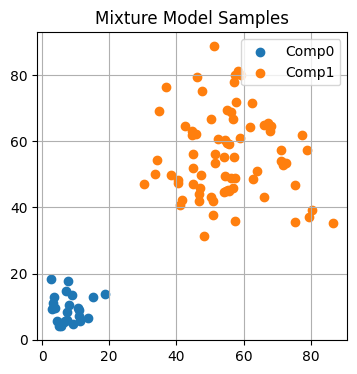

In [93]:
f,ax = plt.subplots(figsize=(4,4))

ax.grid()
ax.set_title("Mixture Model Samples")
ax.scatter(xs.T[0][ids == 0], xs.T[1][ids == 0])
ax.scatter(xs.T[0][ids == 1], xs.T[1][ids == 1])
ax.legend(["Comp0","Comp1"])
plt.show()

In [80]:
#Test2: init model sample from it, draw scatter plot, estimate parameters, check that the estimate is correct.
mus = [np.array([2,2]), np.array([4,4])]
sigmas = [0.2*np.eye(2), 0.05*np.eye(2)]
pis=[0.3,0.7]
mixMod = LogNMixtureModel(2,mus,sigmas,pis)

xs, ids = mixMod.sample(1000)

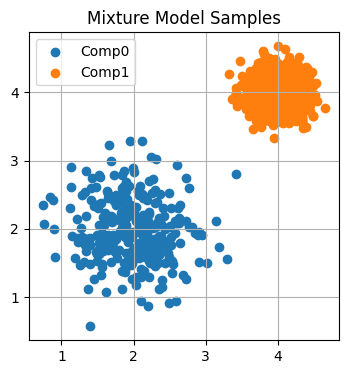

In [81]:
f,ax = plt.subplots(figsize=(4,4))

ax.grid()
ax.set_title("Mixture Model Samples")
ax.scatter(xs.T[0][ids == 0], xs.T[1][ids == 0])
ax.scatter(xs.T[0][ids == 1], xs.T[1][ids == 1])
ax.legend(["Comp0","Comp1"])
plt.show()

In [82]:
mus = [np.zeros([2]), np.zeros([2])]
sigmas = [np.eye(2), np.eye(2)]
pis=[0.9,0.1]
mixMod1 = LogNMixtureModel(2,mus,sigmas,pis)

mixMod1.fit(xs,500)
print(mixMod1)

100%|██████████| 500/500 [00:01<00:00, 498.91it/s]

Means (mus): [[3.99619956 4.00446392]
 [1.98559889 1.97195733]]
Covariances (sigmas): [[[ 0.05131987 -0.00113472]
  [-0.00113472  0.04757665]]

 [[ 0.21307341 -0.01824869]
  [-0.01824869  0.20939082]]]
Weights (pis): [0.70800005 0.29199995]



Параметры должны быть примерно как настоящие, это очень простой случай для EM.

### Переходим к данным

Для оценки количества рабочих можно путём эксперимента подобрать количество кластеров. Попробуйте разное количество кластеров и подберите лучший. Ответьте на вопрос задачи и обоснуйте ваш выбор, используя написанный вами код.

In [119]:
log_Xa = np.log(Xa + 1e-10)
log_Xb = np.log(Xb + 1e-10)

data = np.vstack((log_Xa, log_Xb)).T
import warnings
warnings.filterwarnings("ignore")
Ks = range(1, 10)
log_likelihoods = []

for K in Ks:
    print(f"Обучение модели с K={K}")
    initial_mus = [data[np.random.choice(data.shape[0])] for _ in range(K)]
    initial_sigmas = [np.cov(data, rowvar=False) for _ in range(K)]
    initial_pis = [1/K] * K

    model = LogNMixtureModel(K=K, mus=initial_mus, sigmas=initial_sigmas, pis=initial_pis)
    model.fit(data, nSteps=100)

    final_log_likelihood = model.L_history[-1]
    log_likelihoods.append(final_log_likelihood)

    print(f"Окончательный логарифм правдоподобия для K={K}: {final_log_likelihood}\n")

Обучение модели с K=1


  1%|          | 1/100 [00:00<00:00, 166.74it/s]


Сходимость достигнута на итерации 1
Окончательный логарифм правдоподобия для K=1: 1071.2816591812639

Обучение модели с K=2


  1%|          | 1/100 [00:00<00:00, 161.61it/s]


Сходимость достигнута на итерации 1
Окончательный логарифм правдоподобия для K=2: 1071.2816598683353

Обучение модели с K=3


100%|██████████| 100/100 [00:00<00:00, 401.23it/s]


Окончательный логарифм правдоподобия для K=3: 1158.4683973987285

Обучение модели с K=4


 92%|█████████▏| 92/100 [00:00<00:00, 329.36it/s]


Сходимость достигнута на итерации 92
Окончательный логарифм правдоподобия для K=4: 1166.1377985453942

Обучение модели с K=5


100%|██████████| 100/100 [00:00<00:00, 263.27it/s]


Окончательный логарифм правдоподобия для K=5: 1209.810983160141

Обучение модели с K=6


100%|██████████| 100/100 [00:00<00:00, 211.49it/s]


Окончательный логарифм правдоподобия для K=6: 1218.7367644087344

Обучение модели с K=7


  1%|          | 1/100 [00:00<00:01, 81.05it/s]


Сходимость достигнута на итерации 1
Окончательный логарифм правдоподобия для K=7: 1071.2816607055233

Обучение модели с K=8


100%|██████████| 100/100 [00:00<00:00, 170.54it/s]


Окончательный логарифм правдоподобия для K=8: 1199.052420364028

Обучение модели с K=9


100%|██████████| 100/100 [00:00<00:00, 149.76it/s]

Окончательный логарифм правдоподобия для K=9: 1183.086044738805



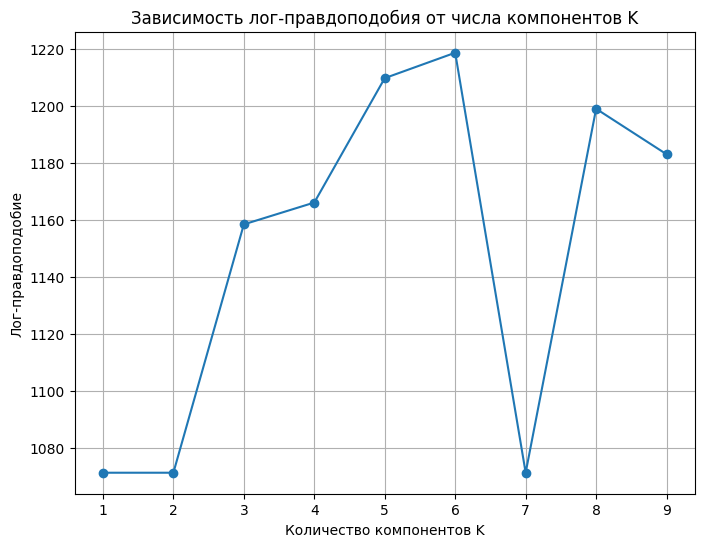

In [123]:
plt.figure(figsize=(8,6))
plt.plot(Ks, log_likelihoods, marker='o')
plt.title("Зависимость лог-правдоподобия от числа компонентов K")
plt.xlabel("Количество компонентов K")
plt.ylabel("Лог-правдоподобие")
plt.grid(True)
plt.show()

100%|██████████| 100/100 [00:01<00:00, 99.42it/s]


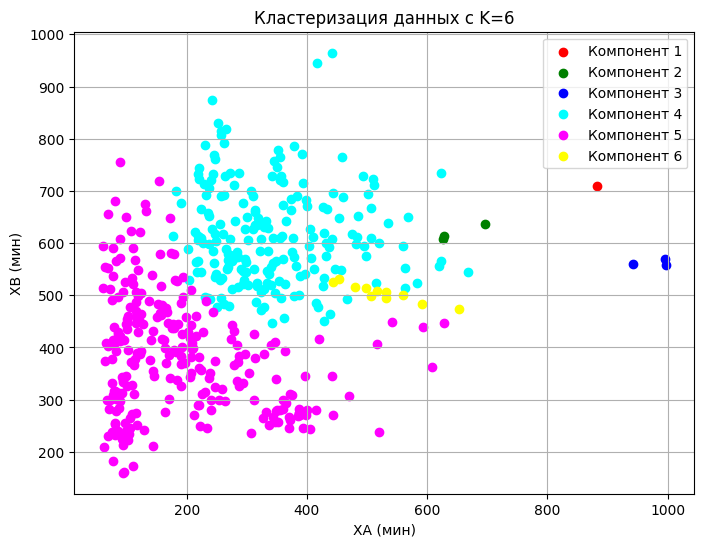

In [127]:
optimal_K = 6

initial_mus = [data[np.random.choice(data.shape[0])] for _ in range(optimal_K)]
initial_sigmas = [np.cov(data, rowvar=False) for _ in range(optimal_K)]
initial_pis = [1/optimal_K] * optimal_K

model_optimal = LogNMixtureModel(K=optimal_K, mus=initial_mus, sigmas=initial_sigmas, pis=initial_pis)
model_optimal.fit(data, nSteps=100)
assigned_components = np.argmax(model_optimal.gammas, axis=1)


plt.figure(figsize=(8,6))
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple']

for k in range(optimal_K):
    cluster_data = data[assigned_components == k]
    plt.scatter(np.exp(cluster_data[:,0]), np.exp(cluster_data[:,1]),
                color=colors[k], label=f"Компонент {k+1}")

plt.title(f"Кластеризация данных с K={optimal_K}")
plt.xlabel("XA (мин)")
plt.ylabel("XB (мин)")
plt.legend()
plt.grid(True)
plt.show()

В ходе эксперимента по продбору наилучшего количества кластеров с помощью логарифма правдоподобия мы пришли к выводу что лучшее значение k = 6.

График лог-правдоподобия показывает рост значения лог-правдоподобия с увеличением числа компонентов, но после K=6 прирост замедляется. Ваша кривая лог-правдоподобия достигла максимума при K=6, и дальнейшее увеличение K не даёт значительного улучшения. При K=6 лог-правдоподобие достигает максимума (около 1218).

На втором графике, который показывает результат кластеризации с K=6, видна чёткая сегментация данных на 6 групп.



## Задача 2. Тотальный контроль (5 баллов)

В чат по теории вероятности сообщения приходят круглосуточно и особенно часто -- в кризисное время, когда у всех проходят коллоквиумы и разные другие контрольные мероприятия. Если выгрузить сырой лог из чата, то можно посчитать длину сообщения в символах $X$ и момент времени $T$, когда сообщение пришло в чат. Предполагается, что $X$ и $T$ независимы, а также промежутки времени $\Delta T_i = T_{i+1} - T_i$ являются независимыми в совокупности.

Исследуя интернет, вы наткнулись на подходящее [экспоненциальное распределение](https://en.wikipedia.org/wiki/Exponential_distribution), которое используется в survival analysis, исследовании времён до происхождения следующего события, которое можно использовать для моделирования времени, и на уже известное [логнормальное распределение](https://en.wikipedia.org/wiki/Log-normal_distribution) для моделирования длины сообщений (несмотря на то, что длины целые, мы попробуем).

На основе наблюдений предложите вероятностную модель на основе смесей распределений, которая помогла бы вам научиться определять, является ли конкретный момент времени $t$, когда было прислано сообщение длины $x$, кризисным.

Как и раньше, действуем по инструкции.

### Посмотрим на датасет

Откройте приложенный датасет и нарисуйте гистограммы для $X_i$ и $\Delta T_i$ -- длин сообщений и времени, прошедшего с предыдущего сообщения.

In [129]:
with open("./terver.pkl","rb") as f:
    dd = pkl.load(f)

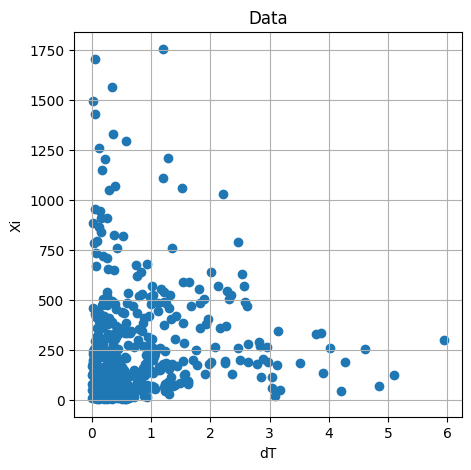

In [130]:
dT = dd['delta-times(min)']
Xi = dd['msgLen']

f,ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Data")
ax.scatter(dT, Xi)
ax.set_xlabel("dT")
ax.set_ylabel("Xi")
plt.show()

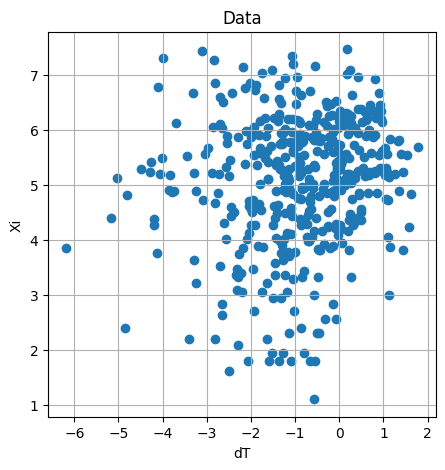

In [131]:
f,ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Data")
ax.scatter(np.log(dT), np.log(Xi))
ax.set_xlabel("dT")
ax.set_ylabel("Xi")
plt.show()

### Модель

Опишите модель смеси, которая вам пригодится для решения задачи.

* Что по смыслу задачи является скрытыми переменными $Y_i$ (номерами компонент)?
* Какое вы можете предложить распределение для пары $(X^i, \Delta T_{i-1})$? Будьте здесь внимательны!
* Какие параметры $\theta$ есть в вероятностной модели?

1) Скрытая переменная $Y$ указывает, в каком состоянии находится каждое сообщение (кризисное или некризисное время).

2) Распределение для $(X, \Delta T)$: В зависимости от состояния $Y$, пара $(X, \Delta T)$ будет описываться логнормальным распределением для длины сообщения $X$ и экспоненциальным распределением для времени $\Delta T$.

3) Параметры: $\pi_i$, $\lambda_i$, $\mu_i$, $\sigma_i^2$.







### Матчасть

Построим математическую основу решения задачи. Выведите и запишите формулы для ЕМ-алгоритма: Е-шаг (вычисление необходимых весов наблюдений) и М-шаг (обновление параметров).

##E-шаг

В $E$-шаге мы вычисляем апостериорные вероятности для каждой компоненты смеси. Для этого нам нужно выразить $\gamma_{ik}$ как вероятность того, что наблюдение $i$ принадлежит компоненте $k$, учитывая все наблюдаемые данные $(X_i, \Delta T_i)$.

Формула для $\gamma_{ik}$:

$$
\gamma_{ik} = p(Y_i = k | (X_i, \Delta T_i)) = \frac{p((X_i, \Delta T_i), Y_i = k)}{\sum_{j=1}^K p((X_i, \Delta T_i), Y_i = j)}
$$

Из теоремы Байеса:

$$
p((X_i, \Delta T_i), Y_i = k) = \pi_k p(X_i | Y_i = k) p(\Delta T_i | Y_i = k)
$$

\

Подставляем выражения для плотностей распределений:

- Плотность для $X_i$ (логнормальное распределение):

$$
p(X_i | Y_i = k) = \frac{1}{X_i \sigma_k \sqrt{2 \pi}} \exp \left( - \frac{(\ln X_i - \mu_k)^2}{2 \sigma_k^2} \right)
$$

- Плотность для $\Delta T_i$ (экспоненциальное распределение):

$$
p(\Delta T_i | Y_i = k) = \lambda_k \exp(-\lambda_k \Delta T_i)
$$

\

Теперь для $\gamma_{ik}$ получаем:

$$
\gamma_{ik} = \frac{\pi_k \cdot \frac{1}{X_i \sigma_k \sqrt{2 \pi}} \exp \left( - \frac{(\ln X_i - \mu_k)^2}{2 \sigma_k^2} \right) \cdot \lambda_k \exp(-\lambda_k \Delta T_i)}{\sum_{j=1}^K \pi_j \cdot \frac{1}{X_i \sigma_j \sqrt{2 \pi}} \exp \left( - \frac{(\ln X_i - \mu_j)^2}{2 \sigma_j^2} \right) \cdot \lambda_j \exp(-\lambda_j \Delta T_i)}
$$

Этот шаг нужно выполнить для каждого наблюдения $i$ и для каждой компоненты $k$.

##M-шаг

В $M$-шаге мы максимизируем функцию правдоподобия, выраженную через $Q(\theta_0, \theta)$, по параметрам $\pi_k$, $\mu_k$, $\sigma_k^2$, $\lambda_k$. Для этого поочередно оптимизируем $Q$ по каждому из параметров.

###Оптимизация по $\pi_k$

Функция $Q$ имеет вид:

$$
Q(\theta_0, \theta) = \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik} \left( \ln \pi_k + \ln p(X_i | Y_i = k) + \ln p(\Delta T_i | Y_i = k) \right)
$$

Для упрощения рассмотрим только термины, которые зависят от $\pi_k$:

$$
Q(\theta_0, \theta) = \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik} \ln \pi_k + \text{другие термины}
$$

Теперь, чтобы максимизировать $Q$ по $\pi_k$, вычисляем производную по $\pi_k$:

$$
\frac{\partial}{\partial \pi_k} Q = \sum_{i=1}^N \gamma_{ik} \cdot \frac{1}{\pi_k} = 0
$$

При этом добавляется условие нормировки:

$$
\sum_{k=1}^K \pi_k = 1
$$

Таким образом, мы получаем:

$$
\pi_k = \frac{\sum_{i=1}^N \gamma_{ik}}{N}
$$

###Оптимизация по $\mu_k$

Теперь оптимизируем по $\mu_k$, параметру логнормального распределения. Для этого из выражения для $Q(\theta_0, \theta)$ выделяем термины, зависящие от $\mu_k$:

$$
Q(\theta_0, \theta) = \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik} \left( - \frac{(\ln X_i - \mu_k)^2}{2 \sigma_k^2} \right)
$$

Вычисляем производную по $\mu_k$:

$$
\frac{\partial}{\partial \mu_k} Q = \sum_{i=1}^N \gamma_{ik} \cdot \frac{\ln X_i - \mu_k}{\sigma_k^2}
$$

Приравниваем к нулю:

$$
\sum_{i=1}^N \gamma_{ik} (\ln X_i - \mu_k) = 0
$$

Решаем относительно $\mu_k$:

$$
\mu_k = \frac{\sum_{i=1}^N \gamma_{ik} \ln X_i}{\sum_{i=1}^N \gamma_{ik}}
$$

###Оптимизация по $\sigma_k^2$

Оптимизация по $\sigma_k^2$ требует минимизации функции:

$$
Q(\theta_0, \theta) = \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik} \left( - \ln \sigma_k^2 - \frac{(\ln X_i - \mu_k)^2}{2 \sigma_k^2} \right)
$$

Вычисляем производную по $\sigma_k^2$:

$$
\frac{\partial}{\partial \sigma_k^2} Q = \sum_{i=1}^N \gamma_{ik} \left( - \frac{1}{2 \sigma_k^2} + \frac{(\ln X_i - \mu_k)^2}{2 \sigma_k^4} \right)
$$

Приравниваем к нулю:

$$
\sum_{i=1}^N \gamma_{ik} \left( - \frac{1}{2 \sigma_k^2} + \frac{(\ln X_i - \mu_k)^2}{2 \sigma_k^4} \right) = 0
$$

Решаем относительно $\sigma_k^2$:

$$
\sigma_k^2 = \frac{\sum_{i=1}^N \gamma_{ik} (\ln X_i - \mu_k)^2}{\sum_{i=1}^N \gamma_{ik}}
$$

###Оптимизация по $\lambda_k$

Для $\lambda_k$, параметра экспоненциального распределения, аналогично находим производную по $\lambda_k$:

$$
Q(\theta_0, \theta) = \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik} \left( \ln \lambda_k - \lambda_k \Delta T_i \right)
$$

Вычисляем производную:

$$
\frac{\partial}{\partial \lambda_k} Q = \sum_{i=1}^N \gamma_{ik} \left( \frac{1}{\lambda_k} - \Delta T_i \right)
$$

Приравниваем к нулю:

$$
\sum_{i=1}^N \gamma_{ik} \cdot \frac{1}{\lambda_k} = \sum_{i=1}^N \gamma_{ik} \Delta T_i
$$

Решаем относительно $\lambda_k$:

$$
\lambda_k = \frac{\sum_{i=1}^N \gamma_{ik}}{\sum_{i=1}^N \gamma_{ik} \Delta T_i}
$$



### Имплементация модели

Будем использовать уже знакомый пайплайн для смеси распределений, который вы видели в семинарах, как основу. Вам предлагается заполнить детали и дописать вычисление Q-функции и лог-правдоподобия для логирования. Предлагаемые тесты смотрите ниже.

* Напишите код модели: начните с заполнения ``init`` и ``sample``, протестируйте, что всё семплится, как вы ожидаете (см. первый тест ниже).
* Добавьте ``fit`` и протестируйте его, он должен корректно оценивать параметры по выборке (см. второй тест ниже)
* Нарисуйте в каждом тесте график зависимости логправдоподобия (по наблюдаемым переменным) и Q-функции от номера итерации, чтобы убедиться, что алгоритм к чему-то сходится.

In [137]:
class CustomMixtureModel:
    '''
    Implements Weibull Mixture Model in R^d
    '''

    def __init__(self,K,lambdas, pis, mus, sigmas):
        """
        Args:
            K (int, optional): number of components.
            mus (list, optional): K entries of (d,), expected values.
            sigmas (list, optional): K entries of (d,d,), covariances.
            pis (list, optional): K floats, weights, positive and sump up to 1.
        """
        self.K = K
        self.pis = np.array(pis)
        self.lambdas = np.array(lambdas)
        self.mus = np.array(mus)
        self.sigmas = np.array(sigmas)
        self.gammas = None

    def __str__(self):
        """Prints the parameters

        Returns:
            out (str): text print
        """
        return f"CustomMixture:\n pis={self.pis},\n mus={self.mus},\n sigmas={self.sigmas},\n lambdas={self.lambdas}"

    def sample(self, N=10):
        """Samples N samples from the model

        Args:
            N (int, optional): number of samples. Defaults to 10.

        Returns:
           result(float[]) : N d-dimensional samples (N,d)
           ids(int[]) : mixture ids (N,)
        """
        result = np.zeros((N, 2))
        ids = np.zeros(N, dtype=int)
        for i in range(N):
            k = np.random.choice(self.K, p=self.pis)
            ids[i] = k
            Xi = np.random.lognormal(mean=self.mus[k], sigma=np.sqrt(self.sigmas[k]))
            Delta_Ti = np.random.exponential(scale=1.0 / self.lambdas[k])
            result[i, 0] = Xi
            result[i, 1] = Delta_Ti
        return result, ids


    def EStep(self, data):
        """Performs E-Step (computation of theta0 weights)

        Args:
            data (float[]): Training data (N,d)
        """
        N = data.shape[0]
        self.gammas = np.zeros((N, self.K))
        Xi = data[:, 0]
        lnXi = np.log(Xi)
        Delta_Ti = data[:, 1]

        for k in range(self.K):
            mu_k = self.mus[k]
            sigma2_k = self.sigmas[k]
            sigma_k = np.sqrt(sigma2_k)
            lambda_k = self.lambdas[k]

            p_Xi_given_k = (1 / (Xi * sigma_k * np.sqrt(2 * np.pi))) * \
                np.exp(- (lnXi - mu_k) ** 2 / (2 * sigma2_k))
            p_DeltaTi_given_k = lambda_k * np.exp(-lambda_k * Delta_Ti)

            self.gammas[:, k] = self.pis[k] * p_Xi_given_k * p_DeltaTi_given_k

        self.gammas = self.gammas / self.gammas.sum(axis=1, keepdims=True)

    def MStep(self, data):
        """Performs M-Step (weight update)

        Args:
            data (float[]): Training data (N,d)
        """
        N = data.shape[0]
        Xi = data[:, 0]
        lnXi = np.log(Xi)
        Delta_Ti = data[:, 1]

        Nk = self.gammas.sum(axis=0)
        self.pis = Nk / N

        for k in range(self.K):
            gamma_k = self.gammas[:, k]
            Nk_k = Nk[k]

            mu_k = (gamma_k * lnXi).sum() / Nk_k
            self.mus[k] = mu_k

            sigma2_k = (gamma_k * (lnXi - mu_k) ** 2).sum() / Nk_k
            self.sigmas[k] = sigma2_k

            lambda_k = Nk_k / (gamma_k * Delta_Ti).sum()
            self.lambdas[k] = lambda_k

    def fit(self, data, nSteps):
        """Fits the model

        Args:
            data (float[]): (batch, d), given data
            nSteps (int): number of steps for EM
        """
        self.Q_history = []
        self.loglike_history = []
        for _ in tqdm.tqdm(np.arange(nSteps)):
            self.EStep(data)
            self.MStep(data)
            Q_value = self._Qfun(data)
            self.Q_history.append(Q_value)
            loglike_value = self._loglike(data)
            self.loglike_history.append(loglike_value)

    def _Qfun(self,data):
        """Computes Q-function

        Args:
            data (float[]): given data (N,2)
        Returns:
            qfun (float): Qfunction value
        """
        Xi = data[:, 0]
        lnXi = np.log(Xi)
        Delta_Ti = data[:, 1]
        Q = 0.0

        for k in range(self.K):
            gamma_k = self.gammas[:, k]
            mu_k = self.mus[k]
            sigma2_k = self.sigmas[k]
            sigma_k = np.sqrt(sigma2_k)
            lambda_k = self.lambdas[k]
            ln_pi_k = np.log(self.pis[k])

            ln_p_Xi_given_k = - np.log(Xi * sigma_k * np.sqrt(2 * np.pi)) - (lnXi - mu_k) ** 2 / (2 * sigma2_k)
            ln_p_DeltaTi_given_k = np.log(lambda_k) - lambda_k * Delta_Ti
            Q += np.sum(gamma_k * (ln_pi_k + ln_p_Xi_given_k + ln_p_DeltaTi_given_k))

        return Q

    def _loglike(self,data):
        """Computes observable log-likelihood

        Args:
            data (float[]): given data (N,2)
        Returns:
            loglike (float): log-likelihood value
        """
        Xi = data[:, 0]
        lnXi = np.log(Xi)
        Delta_Ti = data[:, 1]
        N = data.shape[0]
        loglike = 0.0

        for i in range(N):
            likelihood_i = 0.0
            for k in range(self.K):
                pi_k = self.pis[k]
                mu_k = self.mus[k]
                sigma2_k = self.sigmas[k]
                sigma_k = np.sqrt(sigma2_k)
                lambda_k = self.lambdas[k]

                p_Xi_given_k = (1 / (Xi[i] * sigma_k * np.sqrt(2 * np.pi))) * \
                    np.exp(- (lnXi[i] - mu_k) ** 2 / (2 * sigma2_k))
                p_DeltaTi_given_k = lambda_k * np.exp(-lambda_k * Delta_Ti[i])
                likelihood_i += pi_k * p_Xi_given_k * p_DeltaTi_given_k

            loglike += np.log(likelihood_i)

        return loglike

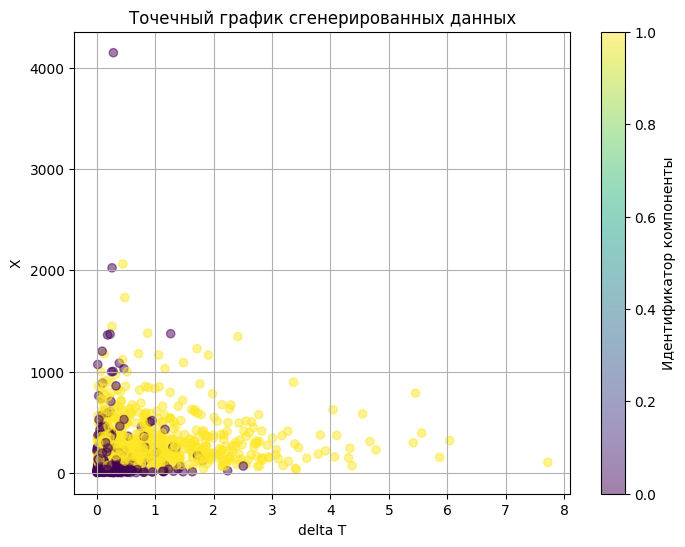

In [145]:
#Test1: init model and sample from it, draw scatter plot
K = 2
pis = [0.3, 0.7]
mus = [4.0, 5.5]
sigmas = [2.0, 0.5]
lambdas = [3.0, 1.0]

model = CustomMixtureModel(K=K, lambdas=lambdas, pis=pis, mus=mus, sigmas=sigmas)

N = 1000
data, ids = model.sample(N)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data[:, 1], data[:, 0], c=ids, cmap='viridis', alpha=0.5)
plt.xlabel('delta T')
plt.ylabel('X')
plt.title('Точечный график сгенерированных данных')
plt.colorbar(scatter, label='Идентификатор компоненты')
plt.grid(True)
plt.show()

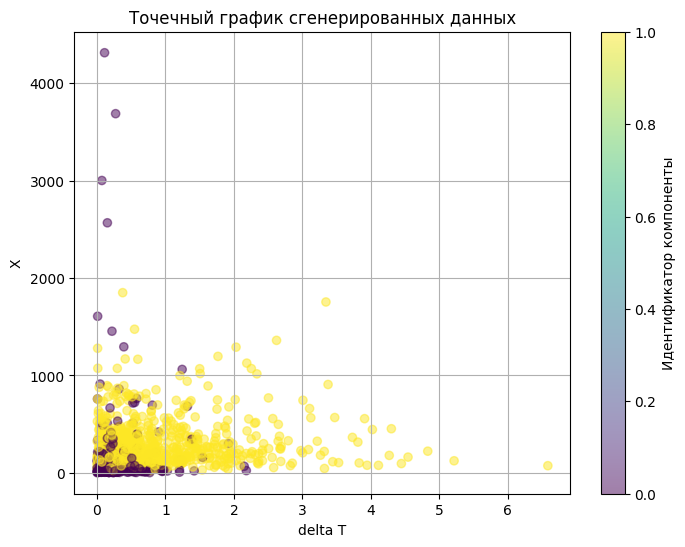

In [146]:
#Test2: init model sample from it, draw scatter plot, estimate parameters, check that the estimate is correct.

K = 2
true_pis = [0.3, 0.7]
true_mus = [4.0, 5.5]
true_sigmas = [2.0, 0.5]
true_lambdas = [3.0, 1.0]

true_model = CustomMixtureModel(K=K, lambdas=true_lambdas, pis=true_pis, mus=true_mus, sigmas=true_sigmas)

N = 1000
data, ids = true_model.sample(N)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data[:, 1], data[:, 0], c=ids, cmap='viridis', alpha=0.5)
plt.xlabel('delta T')
plt.ylabel('X')
plt.title('Точечный график сгенерированных данных')
plt.colorbar(scatter, label='Идентификатор компоненты')
plt.grid(True)
plt.show()

100%|██████████| 500/500 [00:07<00:00, 65.14it/s]


Оцененные параметры:
pis=[0.69331347 0.30668653]
mus=[5.45232411 4.03088089]
sigmas=[0.52542087 2.05495292]
lambdas=[1.07284995 3.19958665]


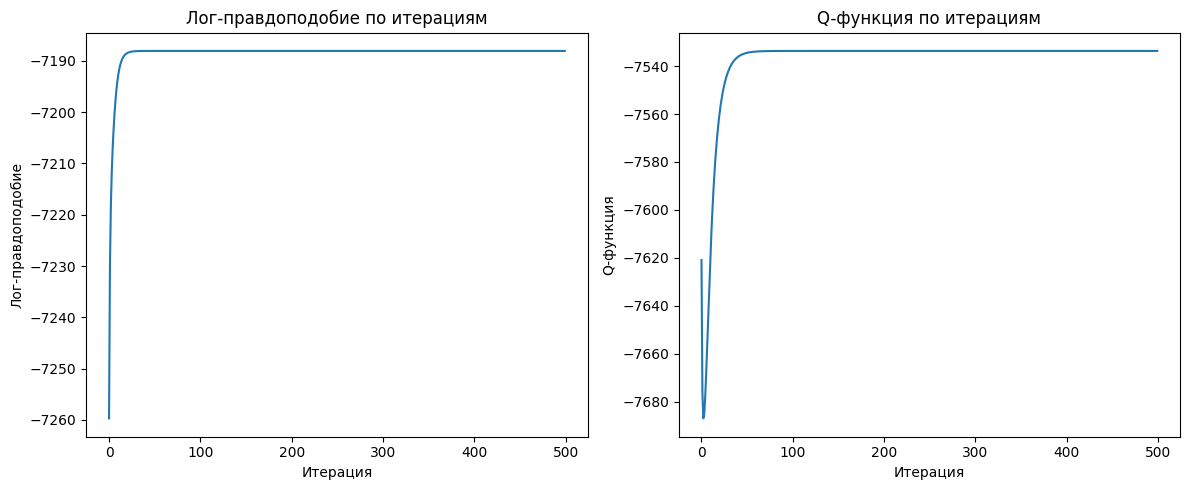

In [147]:
np.random.seed(42)
init_pis = np.random.dirichlet(np.ones(K))
init_mus = np.random.uniform(3.0, 6.0, size=K)
init_sigmas = np.random.uniform(0.1, 3.0, size=K)
init_lambdas = np.random.uniform(0.5, 5.0, size=K)

model = CustomMixtureModel(K=K, lambdas=init_lambdas, pis=init_pis, mus=init_mus, sigmas=init_sigmas)

nSteps = 500
model.fit(data, nSteps)

print('Оцененные параметры:')
print(f'pis={model.pis}')
print(f'mus={model.mus}')
print(f'sigmas={model.sigmas}')
print(f'lambdas={model.lambdas}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model.loglike_history)
plt.xlabel('Итерация')
plt.ylabel('Лог-правдоподобие')
plt.title('Лог-правдоподобие по итерациям')

plt.subplot(1, 2, 2)
plt.plot(model.Q_history)
plt.xlabel('Итерация')
plt.ylabel('Q-функция')
plt.title('Q-функция по итерациям')

plt.tight_layout()
plt.show()

### Ответы

Какие сообщения были написаны в кризисное время, а какие в нормальное?

Какая доля сообщений была написана в кризисное время?

Обоснуйте свои ответы, используя ваш код.

После выполнения Е-шага, у нас есть значения $y$ для каждой компоненты. Если считать что например компоненте с большим значением $\lambda$ (то есть меньшими промежутками) соответствует кризисное время, то для каждого сообщения можно выбрать ту компоненту, которая имеет наибольшую апостериорную вероятность.

Следовательно, сообщения, написанные в кризисное время: Это те сообщения, для которых максимальная апостериорная вероятность принадлежит кризисной компоненте.


In [148]:
crisis_component = np.argmax(model.lambdas)

crisis_messages = (np.argmax(model.gammas, axis=1) == crisis_component)
crisis_fraction = np.mean(crisis_messages)

print("Какая доля сообщений была написана в кризисное время:", crisis_fraction)

Какая доля сообщений была написана в кризисное время: 0.22


Этот подход работает, потому что, согласно нашей модели, кризисное время — это когда сообщения приходят чаще, с короткими интервалами между ними. Чем выше параметр $\lambda$ в экспоненциальном распределении, тем меньше среднее время между сообщениями, то есть такие сообщения более плотно следуют друг за другом. Поэтому мы считаем, что компонент с самым высоким значением $\lambda$ соответствует кризисному времени.

Чтобы определить, какое сообщение относится к кризису, мы смотрим на вероятность того, что каждое сообщение относится к этому кризисному компоненту. Если вероятность максимальна для кризисного компонента, то мы считаем, что сообщение написано в кризисное время.